# Data Preprocessing

This notebook will preprocess the provided data. This will entail the following steps:

Splitting the images in training and validation datasets

Calculation of mean and standard deviation across the entire sample for data normalization

Loading all data and label data

Normalization and standardization of the image data using the computed channel-wise means and standard deviations

Saving data as NumPy arrays in training/validation folder structure

In [4]:
# Load required libraries
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

import numpy as np

# Import custom functions
from functions import change_img_to_label_path

In [5]:
root_path = Path("data/tissue_images/")

Loop across all subjects and split between training and validation data

In [6]:
all_files = list(root_path.glob("*tif"))  # Get list of all tif file paths in root_path 
print('{} images to Process'.format(len(all_files)))
print('---')
val = round(len(all_files) * 0.2)
train = len(all_files) - val

print('{} images for Training'.format(train))
print('{} images for Validation'.format(val))

28 images to Process
---
22 images for Training
6 images for Validation


### Data Normalization and Standardization

To train the neuronal network, data normalization and standardization are crucial. 

Typical RGB images range between 0 and 255 per color channel. The normalization procedure will scale the images to range between 0 and 1. The standardization will be performed with a z-transformation for each channel. The z-transformation scales all data using mean and standard deviation: 
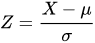

The script will calculate the channel-wise mean and standard deviation across the entire sample for subsequent z-transformations.  

In [7]:
# First, we loop across all files to compute sample mean and std per channel  

# Create empty lists 
means = []
stds = []

for counter, path_to_img in enumerate(tqdm(all_files)):
     
    # Load the data and normalize by 255 (RGB max)
    img = np.asarray(Image.open(path_to_img)) / 255
    
    # Calculate the image mean and standard deviation, and append them to the predifined lists.
    means.append(img.mean(axis = (0,1)))
    stds.append(img.std(axis = (0,1)))

# Convert lists to numpy arrays and calculate sample mean and standard deviation 
channel_means = np.array(means).mean(axis = 0)
channel_stds = np.array(stds).mean(axis = 0)

print('Means per RGB channel = {}'.format(channel_means))
print('Standard deviations per RGB channel = {}'.format(channel_stds))



  0%|          | 0/28 [00:00<?, ?it/s]

Means per RGB channel = [0.53955701 0.38888616 0.56235658]
Standard deviations per RGB channel = [0.21415865 0.2144178  0.16906027]


In [9]:
def standardize(img, means, stds):
    """
    Channel-wise z-transformation to standardize imgages within the given sample 
    """
    
    # Create an empty array similar to the image dataset
    img_normalized = np.zeros_like(img)
    
    # Loop over channels, to perform channel-wise z-transformation using external mean and standard deviations 
    for i in range(img.shape[-1]):
        img_normalized[...,i] = (img[...,i] - means[...,i]) / stds[...,i]

    
    return img_normalized

This function will be stored in the local functions.py file for future use. 

### Preprocessing Loop

This loop will go through the folder structure, read the image and label data, perform standardization and normalization, and save image and label data as separate NumPy arrays  

In [10]:
preprocess_path = Path("./preprocessed/") 

for counter, path_to_img in enumerate(tqdm(all_files)):
    
    # Load the image data and normalize by 255 (RGB max)
    img = np.asarray(Image.open(path_to_img)).astype(np.float32) / 255
    
    # Load label data as boolean array
    mask = np.asarray(Image.open(change_img_to_label_path(path_to_img))).astype(bool)
    
    # Standardize per Channel using pre calculated means and stand deviations
    img_standardize = standardize(img, channel_means, channel_stds)
    
    # Define save path based on counter
    if counter < train:
        current_path = preprocess_path/'train'/str(counter)
    else: 
        current_path = preprocess_path/'val'/str(counter)
    
    # Define save paths for img and mask data 
    current_path_img = current_path/'data'
    current_path_mask = current_path/'masks'
    
    # Make paths for img and mask data
    current_path_img.mkdir(parents=True, exist_ok=True)
    current_path_mask.mkdir(parents=True, exist_ok=True)
    
    # Save data 
    np.save(current_path_img/'01.npy', img_standardize)
    np.save(current_path_mask/'01.npy', mask)
    


  0%|          | 0/28 [00:00<?, ?it/s]

Preprocessing done